In [1]:
#conectamos con google colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# algunas librerias a utilizar

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import cv2
import os

In [3]:
ruta_labels = '/content/drive/MyDrive/modulo 6/chinese_mnist.csv' # aquí se puede colocar la muestra como sample_chinese_mnist.csv

In [4]:
# lectura del csv donde se encuentra la información de las etiquetas de cada imagen

labels = pd.read_csv(ruta_labels)
labels.head()

,suite_id,sample_id,code,value,character
0,1,1,10,9,九
1,1,10,10,9,九
2,1,2,10,9,九
3,1,3,10,9,九
4,1,4,10,9,九


In [5]:
labels.isnull().sum() # revisamos si hay algún valor faltante en el csv

,0
suite_id,0
sample_id,0
code,0
value,0
character,0


In [6]:
image_name = [f"input_{labels['suite_id'][i]}_{labels['sample_id'][i]}_{labels['code'][i]}.jpg" for i in range(len(labels))]  # realizamos una lista que tiene el nombre de cada imagen, ya que en el csv no se encuentra
                                                                                                                              # explicito el nombre de la iamgen

labels['image_name'] = np.array(image_name) # agregamos los nombres de las iamgenes al arreglo
labels = labels[['code', 'character', 'image_name']]  # sólo nos quedamos con las columnas de interés
labels = labels.copy() # paso para evitar un warning de la siguiente linea
labels['code'] = labels['code']-1  # se resta uno a los códigos de los digitos para que de esa forma los códigos o clases empiecen desde 0

labels

,code,character,image_name
0,9,九,input_1_1_10.jpg
1,9,九,input_1_10_10.jpg
2,9,九,input_1_2_10.jpg
3,9,九,input_1_3_10.jpg
4,9,九,input_1_4_10.jpg
...,...,...,...
14995,8,八,input_99_5_9.jpg
14996,8,八,input_99_6_9.jpg
14997,8,八,input_99_7_9.jpg
14998,8,八,input_99_8_9.jpg


In [7]:
# realizamos un dataframe donde estarán sólo los caracteres y sus correspodientes códigos

character = pd.DataFrame({'code':labels['code'].unique(), 'character':labels['character'].unique()})
character = character.sort_values(by='code')
character = character.reset_index(drop=True)
character

,code,character
0,0,零
1,1,一
2,2,二
3,3,三
4,4,四
5,5,五
6,6,六
7,7,七
8,8,八
9,9,九


In [8]:
ruta_font = '/content/drive/MyDrive/modulo 6/MSYH.TTC'

font = FontProperties(fname=ruta_font)  # importante debido a que de esta manera matplotlib podrá escrbir los caracteres chinos en los gráficos

In [9]:
random_images = np.random.randint(0, len(labels), size=25)  # seleccionamos al azar 25 imagénes de las 15,000 que se tienen

In [10]:
ruta_imagenes = '/content/drive/MyDrive/modulo 6/data/'

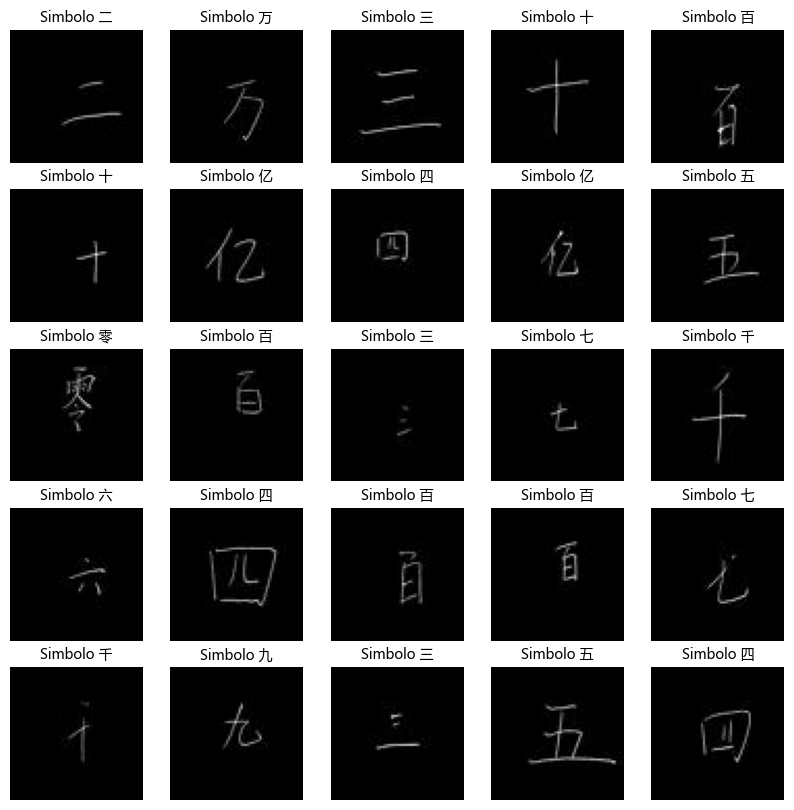

In [11]:
plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_images):
    plt.subplot(5, 5, i + 1)
    img_path = os.path.join(ruta_imagenes, labels['image_name'][idx])
    img = cv2.imread(img_path)
    plt.imshow(img)
    plt.title(f"Simbolo {labels['character'][idx]}", fontproperties=font)
    plt.axis('off')
plt.show()

El paso anterior es ligeramente tardado debido a que se leen imagenes desde google drive, por lo tanto, para evitar que se tomé mucho tiempo, realicé desde mi computadora personal, el procesamiento de esas imagenes a un arreglo 'X_not_filtered', ya que cuento con una copia local de las imagenes, así es más rápido, ya que la lectura desde mi disco es más veloz que la lectura desde drive, después lo subí a google drive e hice la correspondiente lectura, el código para procesar dichas imagenes fue:

```python
X_not_filtered = []
for i in range(len(labels)):
    img_path = os.path.join(ruta_imagenes, labels['image_name'][i])
    image = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE) # se convirtió a escala de grises para evitar
    # dimensiones extra en el arreglo X_not_filtered debido a los colores que podrían ocupar otra dimensión
        
    X_not_filtered.append(image)
    
X_not_filtered = np.array(X_not_filtered)

os.chdir(ruta_arrays)
np.save('X_not_filtered.npy', X_not_filtered)
```

In [12]:
ruta_array = '/content/drive/MyDrive/modulo 6/'

In [13]:
X_not_filtered = np.load(os.path.join(ruta_array, 'X_not_filtered.npy')) # aquí puede ser la muestra X_sample_not_filtered.npy

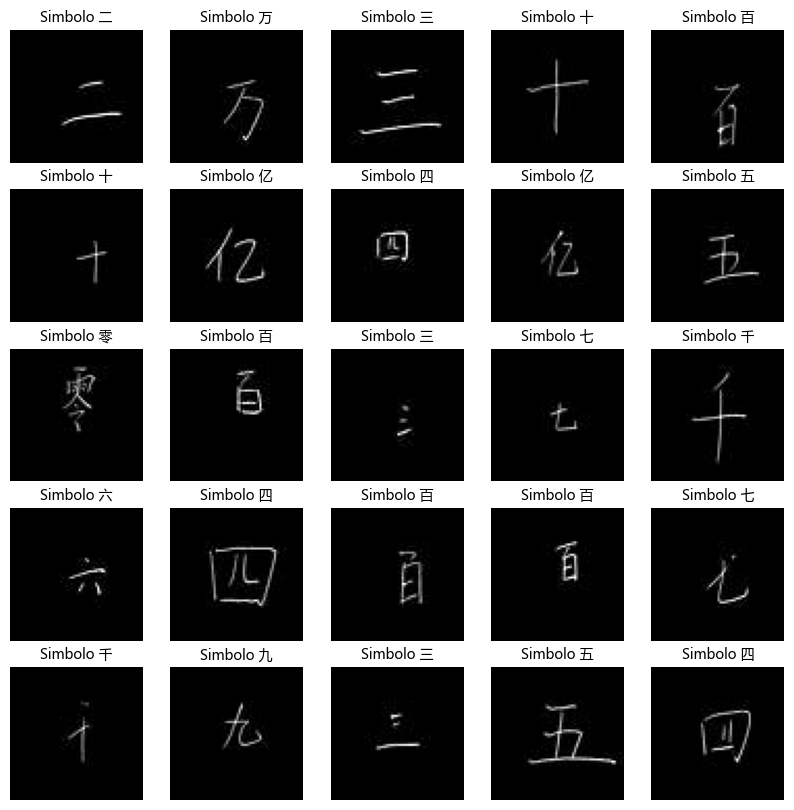

In [14]:
plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_images):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_not_filtered[idx], cmap='gray')
    plt.title(f"Simbolo {labels['character'][idx]}", fontproperties=font)
    plt.axis('off')
plt.show()

Después le apliqué filtros desde mi computadora personal, lo guardé en un nuevo arreglo y lo subí de nuevo a drive, esté fue el código:

```python
X_filtered = []
for i in range(len(labels)):

    img_path = os.path.join(ruta_imagenes, labels['image_name'][i])

    # se convierte a escala de grises y así quitamos dimensiones extra deposibles colores
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # se invierten colores, lo negro paso a blanco y viceversa
    inverted = cv2.bitwise_not(image)

    # desenfoque para reducir ruido
    img_blur = cv2.GaussianBlur(inverted, (1,1), 5)

    # binarizamos la imagen para sólo existan valores de 255 (blanco) o 0 (negro)
    binary = cv2.adaptiveThreshold(img_blur, 255,
                               cv2.ADAPTIVE_THRESH_MEAN_C,
                               cv2.THRESH_BINARY_INV, blockSize=19, C=2)
    
    # se crea una estructura eliptica para reducir ruido
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))

    # operación de apertura morfológica para eliminar pequeños objetos o ruidos
    cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

    # aseguramos que las letras estén en negro y el fondo el blanco además de hacer normalización, quedaran sólo valores 1 y 0
    final = (255 - cleaned)/255
    
    X_filtered.append(final)
    
X_filtered = np.array(X_filtered)

os.chdir(ruta_arrays)
np.save('X_filtered.npy', X_filtered)
```

In [15]:
X_filtered = np.load(os.path.join(ruta_array, 'X_filtered.npy')) # aquí puede ser la muestra X_sample_filtered.npy

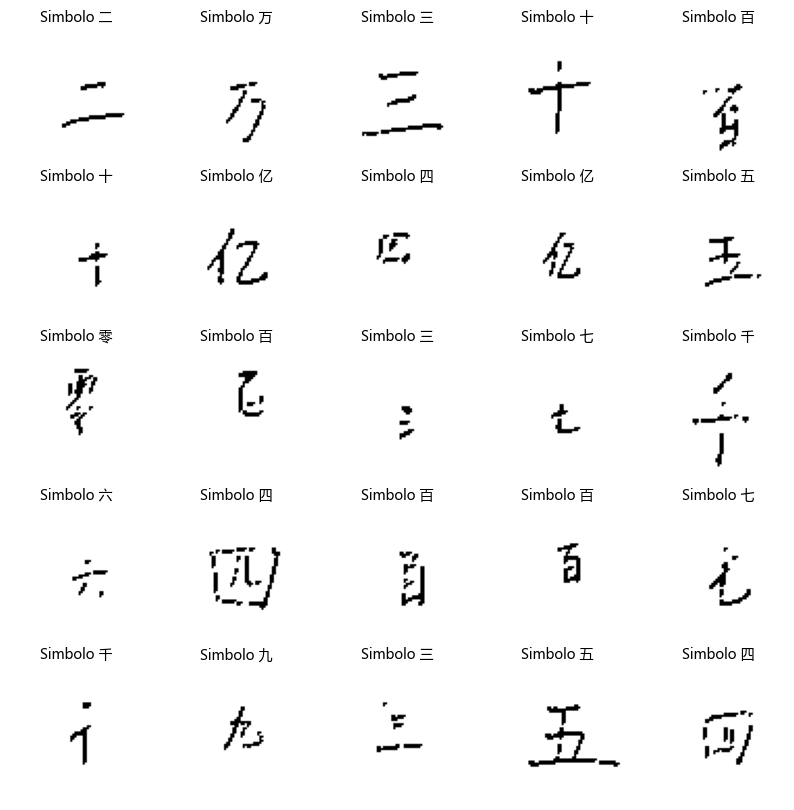

In [16]:
plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_images):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_filtered[idx], cmap='gray')
    plt.title(f"Simbolo {labels['character'][idx]}", fontproperties=font)
    plt.axis('off')
plt.show()

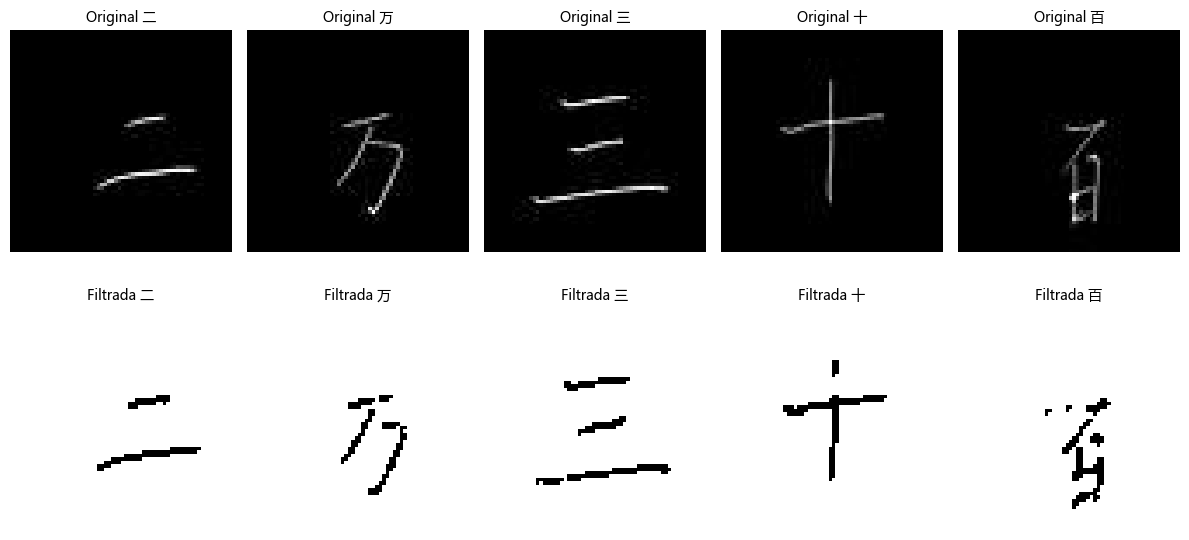

In [17]:
# comparación entre las imagenes origanles y las filtradas

plt.figure(figsize=(12, 6))

for i, idx in enumerate(random_images[:5]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_not_filtered[idx], cmap='gray')
    plt.title(f"Original {labels['character'][idx]}", fontproperties=font)
    plt.axis('off')

    plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(X_filtered[idx], cmap='gray')
    plt.title(f"Filtrada {labels['character'][idx]}", fontproperties=font)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [18]:
# se agregó una dimesión extra para que modelo pueda entender mejor el arreglo

X_not_filtered = X_not_filtered[..., np.newaxis]
X_filtered = X_filtered[..., np.newaxis]

In [19]:
print(X_not_filtered.shape)
print(X_filtered.shape)

(15000, 64, 64, 1)
(15000, 64, 64, 1)


In [20]:
y = pd.DataFrame(labels['code'])
y

,code
0,9
1,9
2,9
3,9
4,9
...,...
14995,8
14996,8
14997,8
14998,8


Lo que haré a continuación será evaluar el modelo tanto para las imagenes filtradas y no filtradas y ver cual tiene mejor desempeño

In [21]:
y['code'].unique() # vemos que los valores unicos de los códigos de los caracteres

array([ 9, 10, 11, 12, 13, 14,  0,  1,  2,  3,  4,  5,  6,  7,  8])

In [22]:
from sklearn.model_selection import train_test_split

# separamos en entrenamiento y prueba pero solo los datos no filtrados

X_train_nf, X_test_nf, y_train, y_test = train_test_split(X_not_filtered, y, test_size=0.23, shuffle = True)


In [23]:
# obtenemos los indices de las imagenes que se harán para entrenamiento y prueba
# de esta manera podremos comparar un poco mejor los modelos, ya que usaron las mismas imagenes con o sin filtro
# y así evitar que algunas imagenes se "vean mejor" con o sin filtro

train_index = np.array(y_train.index)
test_index = np.array(y_test.index)

In [24]:
X_train_f = X_filtered[train_index]
X_test_f = X_filtered[test_index]

In [25]:
y_test.reset_index(drop=True, inplace=True)
y_test

,code
0,8
1,5
2,9
3,11
4,1
...,...
3445,10
3446,6
3447,4
3448,14


In [26]:
# hacemos la categorización de las códigos

from tensorflow.keras.utils import to_categorical

num_classes = len(y['code'].unique())

y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)


## Construcción del modelo para las imagenes no filtradas

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

input_shape = X_train_nf.shape[1:]

model_nf = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(num_classes, activation='softmax')
])

model_nf.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,276,431 (4.87 MB)

 Trainable params: 1,276,431 (4.87 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
from tensorflow.keras.optimizers import Adam

model_nf.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [29]:
history_nf = model_nf.fit(
    X_train_nf, y_train_cat,
    epochs=50,
    batch_size=256,
    verbose=1
)

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.2274 - loss: 6.1685
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8046 - loss: 0.5934
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9217 - loss: 0.2327
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9629 - loss: 0.1169
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9720 - loss: 0.0900
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9795 - loss: 0.0611
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9777 - loss: 0.0648
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9888 - loss: 0.0351
Epoch 9/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9825 - loss: 0.0504
Epoch 10/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9956 - loss: 0.0192
Epoch 11/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9951 - loss: 0.0167
Epoch 12/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy:

In [30]:
test_nf_loss, test_nf_acc = model_nf.evaluate(X_test_nf, y_test_cat)
print(f"Test accuracy: {test_nf_acc:.4f}")

108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9848 - loss: 0.0966
Test accuracy: 0.9870


In [31]:
predictions_nf = model_nf.predict(X_test_nf)
predicted_labels_nf = np.argmax(predictions_nf, axis=1)

108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [32]:
predicted_labels_nf = pd.DataFrame({'code':predicted_labels_nf})
predicted_labels_nf

,code
0,8
1,5
2,9
3,11
4,1
...,...
3445,10
3446,6
3447,4
3448,14


In [33]:
random_test_images = np.random.randint(0, len(y_test), size=25)  # selecccionamos imagenes al azar para ver si fueron bien predichas

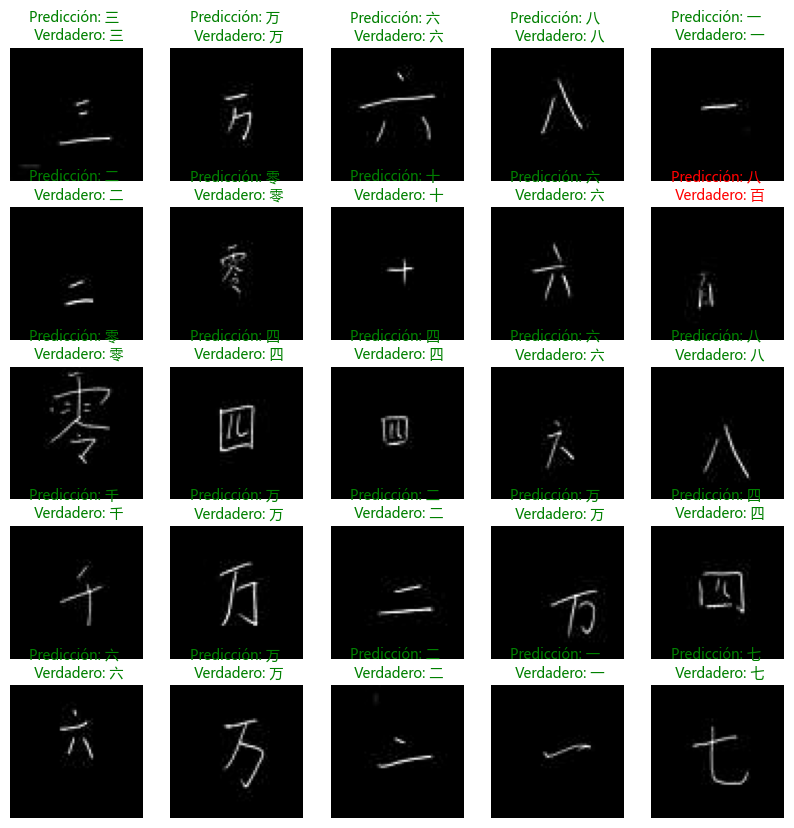

In [34]:
plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_test_images):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_test_nf[idx].squeeze(), cmap='gray')
    color = 'green' if predicted_labels_nf['code'][idx] == y_test['code'][idx] else 'red'
    plt.title(f"Predicción: {(character['character'][predicted_labels_nf['code'][idx]])} \n Verdadero: {(character['character'][y_test['code'][idx]])}", color=color, fontproperties=font)
    plt.axis('off')
plt.show()

## Construcción del modelo para las imagenes filtradas

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

input_shape = X_train_f.shape[1:]  # (height, width, channels)

model_f = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(num_classes, activation='softmax')  # Para clasificación multiclase
])

model_f.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,276,431 (4.87 MB)

 Trainable params: 1,276,431 (4.87 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
from tensorflow.keras.optimizers import Adam

model_f.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [37]:
history_f = model_f.fit(
    X_train_f, y_train_cat,
    epochs=50,
    batch_size=256,
    verbose=1
)

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.1589 - loss: 2.5196
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6245 - loss: 1.1711
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8083 - loss: 0.5747
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8681 - loss: 0.3934
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9117 - loss: 0.2658
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9321 - loss: 0.2042
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9396 - loss: 0.1811
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9496 - loss: 0.1555
Epoch 9/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9581 - loss: 0.1282
Epoch 10/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9619 - loss: 0.1116
Epoch 11/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9655 - loss: 0.1033
Epoch 12/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy:

In [38]:
test_f_loss, test_f_acc = model_f.evaluate(X_test_f, y_test_cat)
print(f"Test accuracy: {test_f_acc:.4f}")

108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9712 - loss: 0.1311
Test accuracy: 0.9672


In [39]:
predictions_f = model_f.predict(X_test_f)
predicted_labels_f = np.argmax(predictions_f, axis=1)

108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [40]:
predicted_labels_f = pd.DataFrame({'code':predicted_labels_f})
predicted_labels_f

,code
0,8
1,5
2,9
3,11
4,1
...,...
3445,10
3446,6
3447,4
3448,9


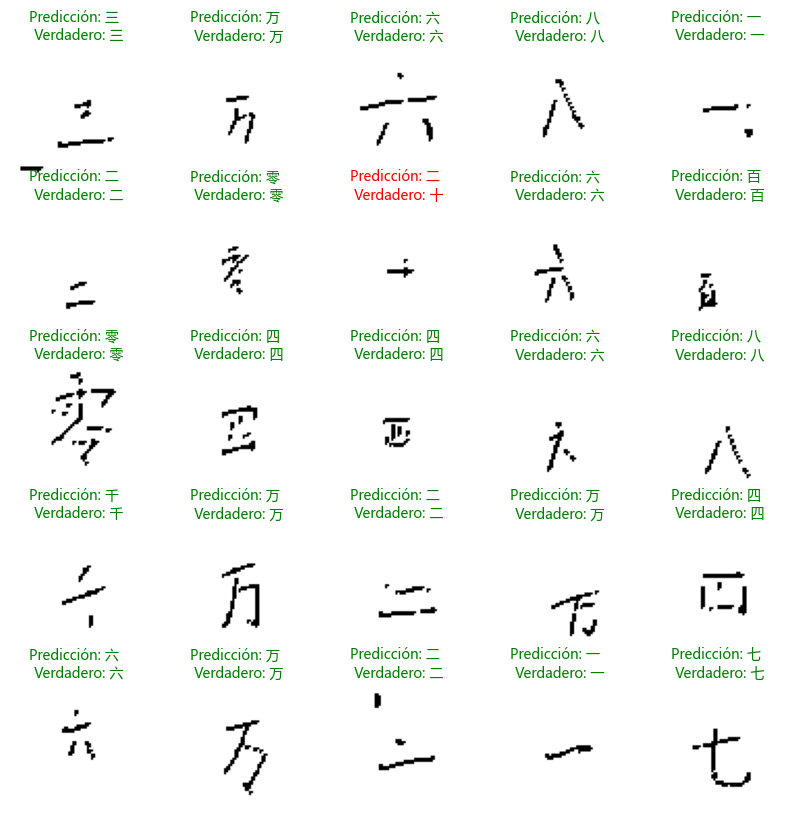

In [41]:
plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_test_images):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_test_f[idx].squeeze(), cmap='gray')
    color = 'green' if predicted_labels_f['code'][idx] == y_test['code'][idx] else 'red'
    plt.title(f"Predicción: {(character['character'][predicted_labels_f['code'][idx]])} \n Verdadero: {(character['character'][y_test['code'][idx]])}", color=color, fontproperties=font)
    plt.axis('off')
plt.show()

## comparativa entre los dos modelos

<ipython-input-45-74c2dd92e32e>:21: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


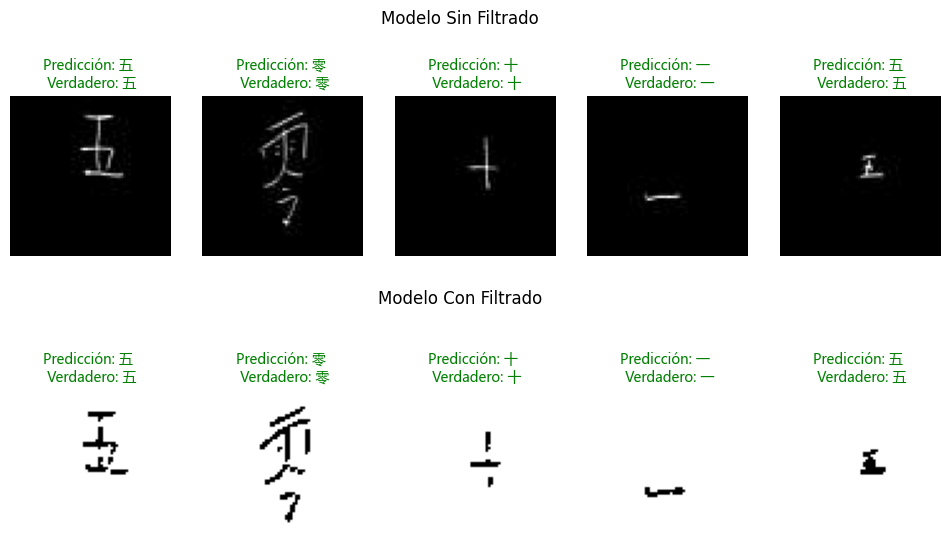

In [45]:
random_images = np.random.choice(len(y_test), size=25)  # verificar si se puede utilizar random_test_images

plt.figure(figsize=(12, 7))

for i, idx in enumerate(random_images[:5]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test_nf[idx], cmap='gray')
    color = 'green' if predicted_labels_nf['code'][idx] == y_test['code'][idx] else 'red'
    plt.title(f"Predicción: {(character['character'][predicted_labels_nf['code'][idx]])} \n Verdadero: {(character['character'][y_test['code'][idx]])}", color=color, fontproperties=font)
    plt.axis('off')

    plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(X_test_f[idx], cmap='gray')
    color = 'green' if predicted_labels_f['code'][idx] == y_test['code'][idx] else 'red'
    plt.title(f"Predicción: {(character['character'][predicted_labels_f['code'][idx]])} \n Verdadero: {(character['character'][y_test['code'][idx]])}", color=color, fontproperties=font)
    plt.axis('off')

plt.text(0.5, 0.93, "Modelo Sin Filtrado", ha='center', va='center', transform=plt.gcf().transFigure, fontsize=12)
plt.text(0.5, 0.53, "Modelo Con Filtrado", ha='center', va='center', transform=plt.gcf().transFigure, fontsize=12)

plt.tight_layout()
plt.show()

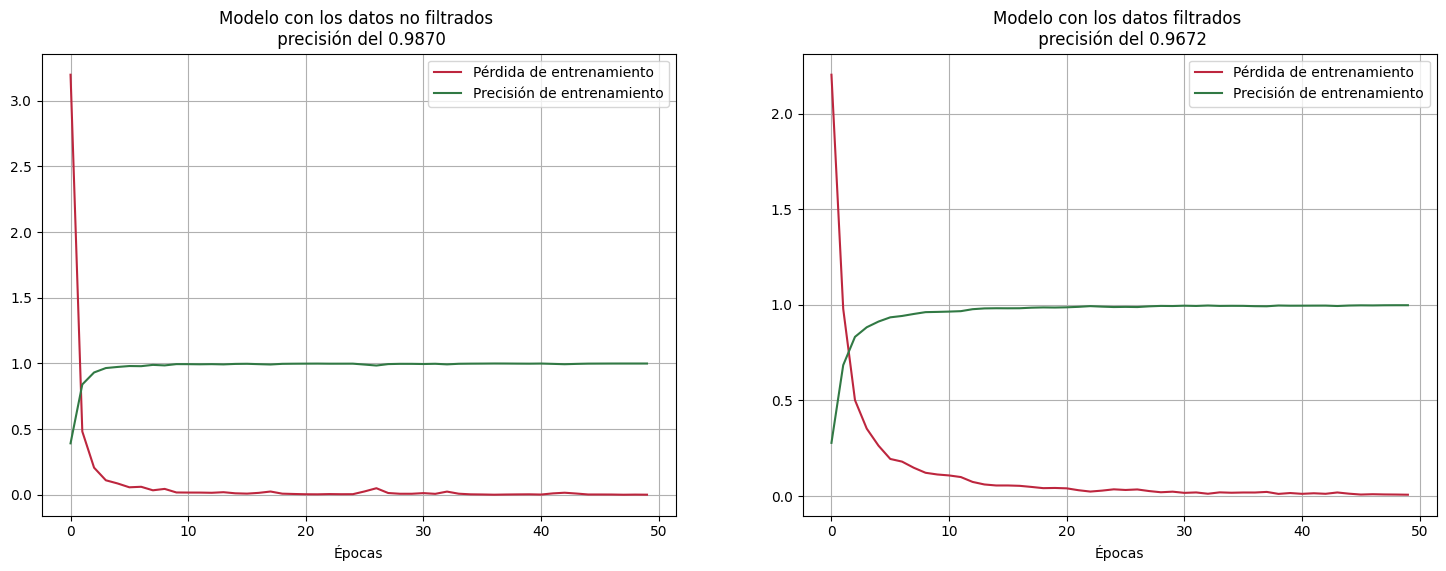

In [46]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.title(f'Modelo con los datos no filtrados \n precisión del {test_nf_acc:.4f}')
plt.plot(history_nf.history['loss'], label='Pérdida de entrenamiento', color = '#BD263E')
plt.plot(history_nf.history['accuracy'], label='Precisión de entrenamiento', color = '#317944')
plt.xlabel('Épocas')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.title(f'Modelo con los datos filtrados \n precisión del {test_f_acc:.4f}')
plt.plot(history_f.history['loss'], label='Pérdida de entrenamiento', color = '#BD263E')
plt.plot(history_f.history['accuracy'], label='Precisión de entrenamiento', color = '#317944')
plt.xlabel('Épocas')
plt.grid()
plt.legend()


Text(0.5, 1.0, 'Datos filtrados')

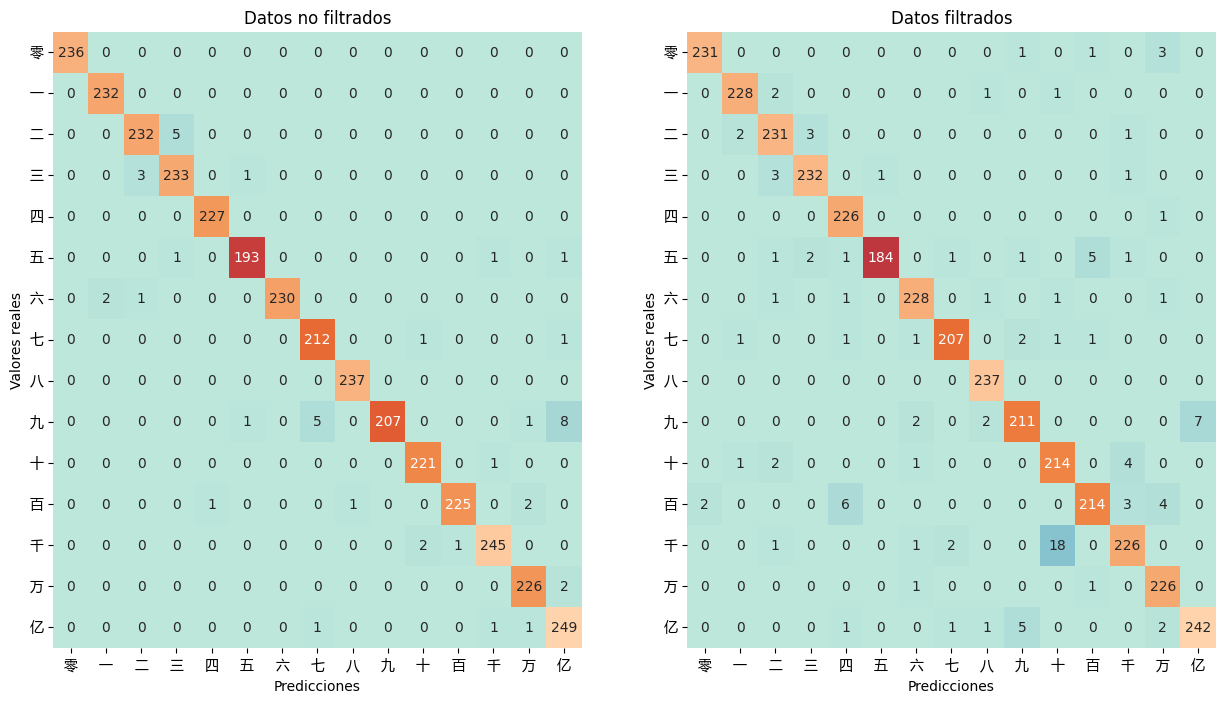

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
cm_nf = confusion_matrix(y_test, predicted_labels_nf)
sns.heatmap(cm_nf, annot=True, fmt='d', cmap='icefire', cbar=False)
plt.xticks(ticks=character['code']+0.5, labels=character['character'], fontproperties=font)
plt.yticks(ticks=character['code']+0.5, labels=character['character'], fontproperties=font, rotation=0)
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.title('Datos no filtrados')

plt.subplot(1, 2, 2)
cm_f = confusion_matrix(y_test, predicted_labels_f)
sns.heatmap(cm_f, annot=True, fmt='d', cmap='icefire', cbar=False)
plt.xticks(ticks=character['code']+0.5, labels=character['character'], fontproperties=font)
plt.yticks(ticks=character['code']+0.5, labels=character['character'], fontproperties=font, rotation=0)
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.title('Datos filtrados')



## Conclusión

Podemos notar que con los datos no filtrados el modelo recibe una ligera mejor precisión que con los datos filtrados, esto se puede deber a que al momento de colocar los filtros ciertos caracteres se cortan o lineas que están muy juntas se pueden unir causando que se pueda interpretar como otro caracter, además de que el al hacer el filtrado del ruido, este no haya logrado quitarse por completo, o se pudo mezclar con los caracteres causando aún más distorsión en ellos, tal vez un filtrado mucho más robusto para evitar dichas situaciones pueda favorecer a la mejora del modelo, pero aun así una precisión arriba de 0.95 es bastante buena.